In [ ]:
# このコードは変更しない
!pip install -U ccml2021
# You must restart the runtimeとメッセージが出たら、ランタイムを再起動する

In [6]:
# 他変数の回帰分析データ
from sklearn import datasets
diabetes = datasets.load_diabetes()
# print(diabetes.DESCR)

X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
scaler_X.fit(X_train)
scaler_y.fit(y_train.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)


In [8]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

models = {
    'PLS': GridSearchCV(
        PLSRegression(),
        param_grid={
            'n_components': [ii + 1 for ii in range(X_train.shape[1])],
        },
        cv=5,
    ),
    'SVR': GridSearchCV(
        SVR(),
        param_grid={
            'gamma': [2**ii for ii in range(-5, 5)],
            'C': [2**ii for ii in range(-5, 5)],
            'epsilon': [2**ii for ii in range(-5, 5)],
        },
        cv=5,
    ),
    'RF': RandomForestRegressor(n_estimators=500),
}

y_train_preds = {}
y_test_preds = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled.flatten())

    y_train_pred_scaled = model.predict(X_train_scaled)
    y_test_pred_scaled = model.predict(X_test_scaled)
    y_train_pred_scaled = y_train_pred_scaled.reshape(-1, 1)
    y_test_pred_scaled = y_test_pred_scaled.reshape(-1, 1)

    y_train_preds[name] = scaler_y.inverse_transform(y_train_pred_scaled)
    y_test_preds[name] = scaler_y.inverse_transform(y_test_pred_scaled)


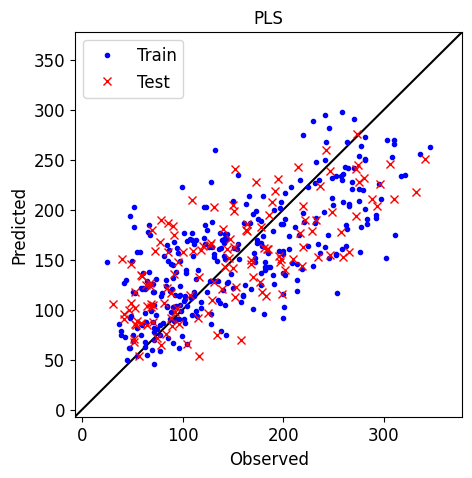

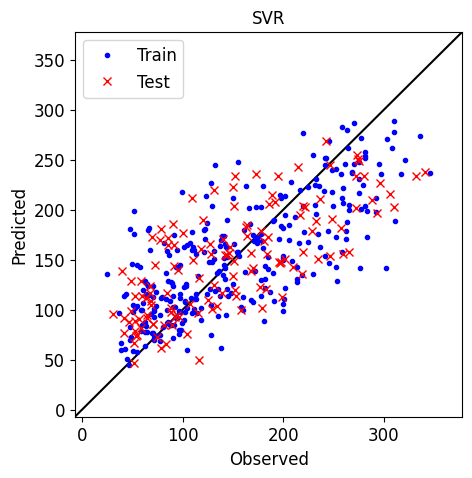

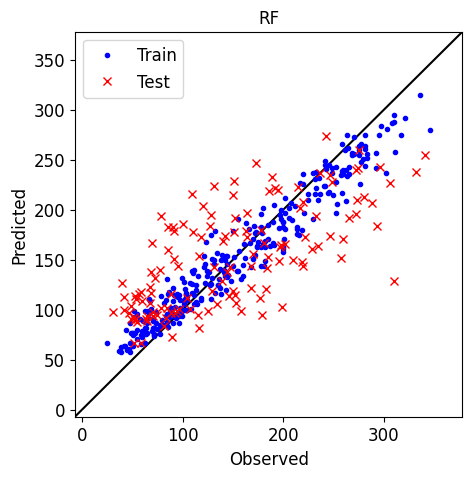

In [10]:
# 実数値-予測値プロット
import matplotlib.pyplot as plt

for name in ['PLS', 'SVR', 'RF']:
    y_train_pred = y_train_preds[name]
    y_test_pred = y_test_preds[name]

    min_val = min(
        min(y_train),
        min(y_train_pred),
        min(y_test),
        min(y_test_pred),
    )
    max_val = max(
        max(y_train),
        max(y_train_pred),
        max(y_test),
        max(y_test_pred),
    )
    margin = (max_val - min_val) * 0.1
    xy_lim = [min_val - margin, max_val + margin]

    fig = plt.figure(figsize=[5, 5])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(xy_lim, xy_lim, 'k-')
    ax.plot(y_train, y_train_pred, 'b.', label='Train')
    ax.plot(y_test, y_test_pred, 'rx', label='Test')
    ax.set_xlim(xy_lim)
    ax.set_ylim(xy_lim)
    ax.set_xlabel('Observed', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(name, fontsize=12)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12)
    fig.savefig('{}.png'.format(name))
    plt.show()


In [13]:
# トレーニングデータとテストデータの各種予測精度評価指標の計算
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.DataFrame(
    index = ['PLS', 'SVR', 'RF'],
    columns= [
        'R2_train', 'MAE_train', 'RMSE_train',
        'R2_test', 'MAE_test', 'RMSE_test',
    ]
)

for name in ['PLS', 'SVR', 'RF']:
    y_train_pred = y_train_preds[name]
    y_test_pred = y_test_preds[name]
    df.loc[name, 'R2_train'] = r2_score(y_train, y_train_pred)
    df.loc[name, 'RMSE_train'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    df.loc[name, 'MAE_train'] = mean_absolute_error(y_train, y_train_pred)
    df.loc[name, 'R2_test'] = r2_score(y_test, y_test_pred)
    df.loc[name, 'RMSE_test'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    df.loc[name, 'MAE_test'] = mean_absolute_error(y_test, y_test_pred)

df

,R2_train,MAE_train,RMSE_train,R2_test,MAE_test,RMSE_test
PLS,0.511298,43.048379,53.869325,0.496858,45.477455,54.394209
SVR,0.554489,39.697724,51.433818,0.522337,43.650191,52.999077
RF,0.919276,17.732472,21.893843,0.471971,46.539474,55.723228


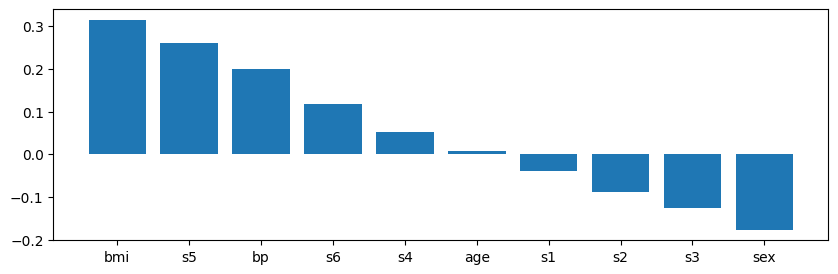

In [14]:
# 説明変数の重要度の確認
importance_PLS = pd.DataFrame(
    {
        'coef': models['PLS'].best_estimator_.coef_.flatten(),
    },
    index = feature_names,
)
importance_PLS.sort_values('coef', ascending=False, inplace=True)
fig = plt.figure(figsize=[10, 3])
ax = fig.add_subplot(1, 1, 1)
ax.bar(importance_PLS.index, importance_PLS['coef'])
fig.savefig('importance_PLS.png')
plt.show()

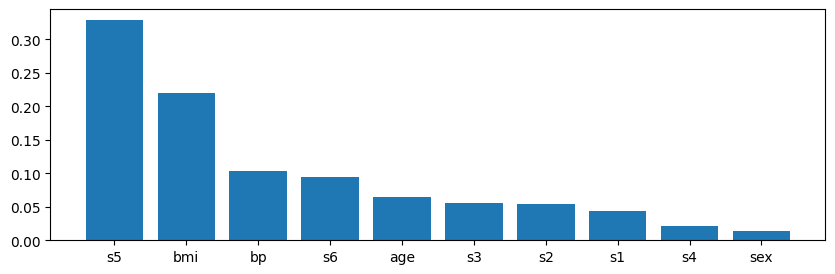

In [17]:
# 大きさの確認
importance_RF = pd.DataFrame(
    {
        'feature_importances': models['RF'].feature_importances_,  
    },
    index = feature_names,
)
importance_RF.sort_values(
    'feature_importances',
    ascending=False,
    inplace=True,
)
fig = plt.figure(figsize=[10, 3])
ax = fig.add_subplot(1, 1, 1)
ax.bar(importance_RF.index, importance_RF['feature_importances'])
fig.savefig('importance_RF.png')
plt.show()

## 考察記入欄

Random ForestはPLSやSVRに比べて、トレーニングデータに対して誤差が小さい一方、テストデータに対しては誤差が大きくなっていることからオーバーフィッティングしていることがわかる。これはRandom Forestがノイズの多いデータに対して有効であることの副作用であると捉えることができる

## 感想記入欄

Random Forestを用いた回帰モデルの構築では、単なる分類に留まらず、各説明変数の重要度が明確に評価できる点が非常に興味深かったです

## 変数名、ファイル名の最終チェック

以下のコードは変更しないでください。

実行することで、上のコードが想定通りの変数名、ファイル名を使用しているかをチェックできます。

In [ ]:
from ccml2021.checker import basic3_2

basic3_2(globals())